<a href="https://www.kaggle.com/code/awesomeharris/ps3e14-prediction-of-wild-blueberry-yield?scriptVersionId=129912050" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

Prediction of Wild Blueberry Yield (Kaggle Competition)  

16 Features Unit Description:  
- Clonesize m2: The average blueberry clone size in the field  
- Honeybee bees/m2/min: Honeybee density in the field  
- Bumbles bees/m2/min: Bumblebee density in the field  
- Andrena bees/m2/min: Andrena bee density in the field  
- Osmia bees/m2/min: Osmia bee density in the field  
- MaxOfUpperTRange ℃: The highest record of the upper band daily air temperature during the bloom season  
- MinOfUpperTRange ℃: The lowest record of the upper band daily air temperature  
- AverageOfUpperTRange ℃: The average of the upper band daily air temperature  
- MaxOfLowerTRange ℃: The highest record of the lower band daily air temperature  
- MinOfLowerTRange ℃: The lowest record of the lower band daily air temperature  
- AverageOfLowerTRange ℃: The average of the lower band daily air temperature  
- RainingDays Day: The total number of days during the bloom season, each of which has precipitation larger than zero  
- AverageRainingDays Day: The average of raining days of the entire bloom season
- Fruitset: the percentage of blossoms which end up forming fruits
- Fruitmass: The average mass of fruit
- Seeds: The number of seeds in a set

Prediction Target:  
- Yield


## Getting Started

#### Import libraries

In [1]:
# Import warnings
import warnings
warnings.filterwarnings("ignore")
import logging

# Import Neccessary libraries
import numpy as np 
import pandas as pd

# Import Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import plotly.express as px

# Import Statistics libraries
from scipy import stats
from scipy.stats import norm
from scipy.cluster.hierarchy import linkage, dendrogram

# Import ML libraries

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import VotingRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Import Optuna
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import r2_score
# Set the log level for the optuna package to WARNING
optuna.logging.set_verbosity(optuna.logging.WARNING)

#### Import dataset

In [2]:
path_origin = '/kaggle/input/wild-blueberry-yield-prediction-dataset/WildBlueberryPollinationSimulationData.csv'
path_train = '/kaggle/input/playground-series-s3e14/train.csv'
path_test = '/kaggle/input/playground-series-s3e14/test.csv'
path_sample = '/kaggle/input/playground-series-s3e14/sample_submission.csv'

data_origin = pd.read_csv(path_origin).drop(columns='Row#')
data_train = pd.read_csv(path_train).drop(columns='id')
data_test = pd.read_csv(path_test)
id_test = data_test.pop('id') # id column required for submission file

In [3]:
data_train.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [4]:
print('Shape of origin dataset is',data_origin.shape)
print('Shape of train dataset is',data_train.shape)
print('Shape of test dataset is',data_test.shape)

print('Any null values in origin dataset?',data_origin.isnull().any().any())
print('Any null values in train dataset?',data_train.isnull().any().any())
print('Any null values in test dataset?',data_test.isnull().any().any())

Shape of origin dataset is (777, 17)
Shape of train dataset is (15289, 17)
Shape of test dataset is (10194, 16)
Any null values in origin dataset? False
Any null values in train dataset? False
Any null values in test dataset? False


In [5]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   clonesize             15289 non-null  float64
 1   honeybee              15289 non-null  float64
 2   bumbles               15289 non-null  float64
 3   andrena               15289 non-null  float64
 4   osmia                 15289 non-null  float64
 5   MaxOfUpperTRange      15289 non-null  float64
 6   MinOfUpperTRange      15289 non-null  float64
 7   AverageOfUpperTRange  15289 non-null  float64
 8   MaxOfLowerTRange      15289 non-null  float64
 9   MinOfLowerTRange      15289 non-null  float64
 10  AverageOfLowerTRange  15289 non-null  float64
 11  RainingDays           15289 non-null  float64
 12  AverageRainingDays    15289 non-null  float64
 13  fruitset              15289 non-null  float64
 14  fruitmass             15289 non-null  float64
 15  seeds              

In [6]:
data_train.describe().T

,count,mean,std,min,25%,50%,75%,max
clonesize,15289.0,19.704690,6.595211,10.000000,12.500000,25.000000,25.000000,40.000000
honeybee,15289.0,0.389314,0.361643,0.000000,0.250000,0.500000,0.500000,18.430000
bumbles,15289.0,0.286768,0.059917,0.000000,0.250000,0.250000,0.380000,0.585000
andrena,15289.0,0.492675,0.148115,0.000000,0.380000,0.500000,0.630000,0.750000
osmia,15289.0,0.592355,0.139489,0.000000,0.500000,0.630000,0.750000,0.750000
MaxOfUpperTRange,15289.0,82.169887,9.146703,69.700000,77.400000,86.000000,86.000000,94.600000
MinOfUpperTRange,15289.0,49.673281,5.546405,39.000000,46.800000,52.000000,52.000000,57.200000
AverageOfUpperTRange,15289.0,68.656256,7.641807,58.200000,64.700000,71.900000,71.900000,79.000000
MaxOfLowerTRange,15289.0,59.229538,6.610640,50.200000,55.800000,62.000000,62.000000,68.200000
MinOfLowerTRange,15289.0,28.660553,3.195367,24.300000,27.000000,30.000000,30.000000,33.000000


## Feature Distribution

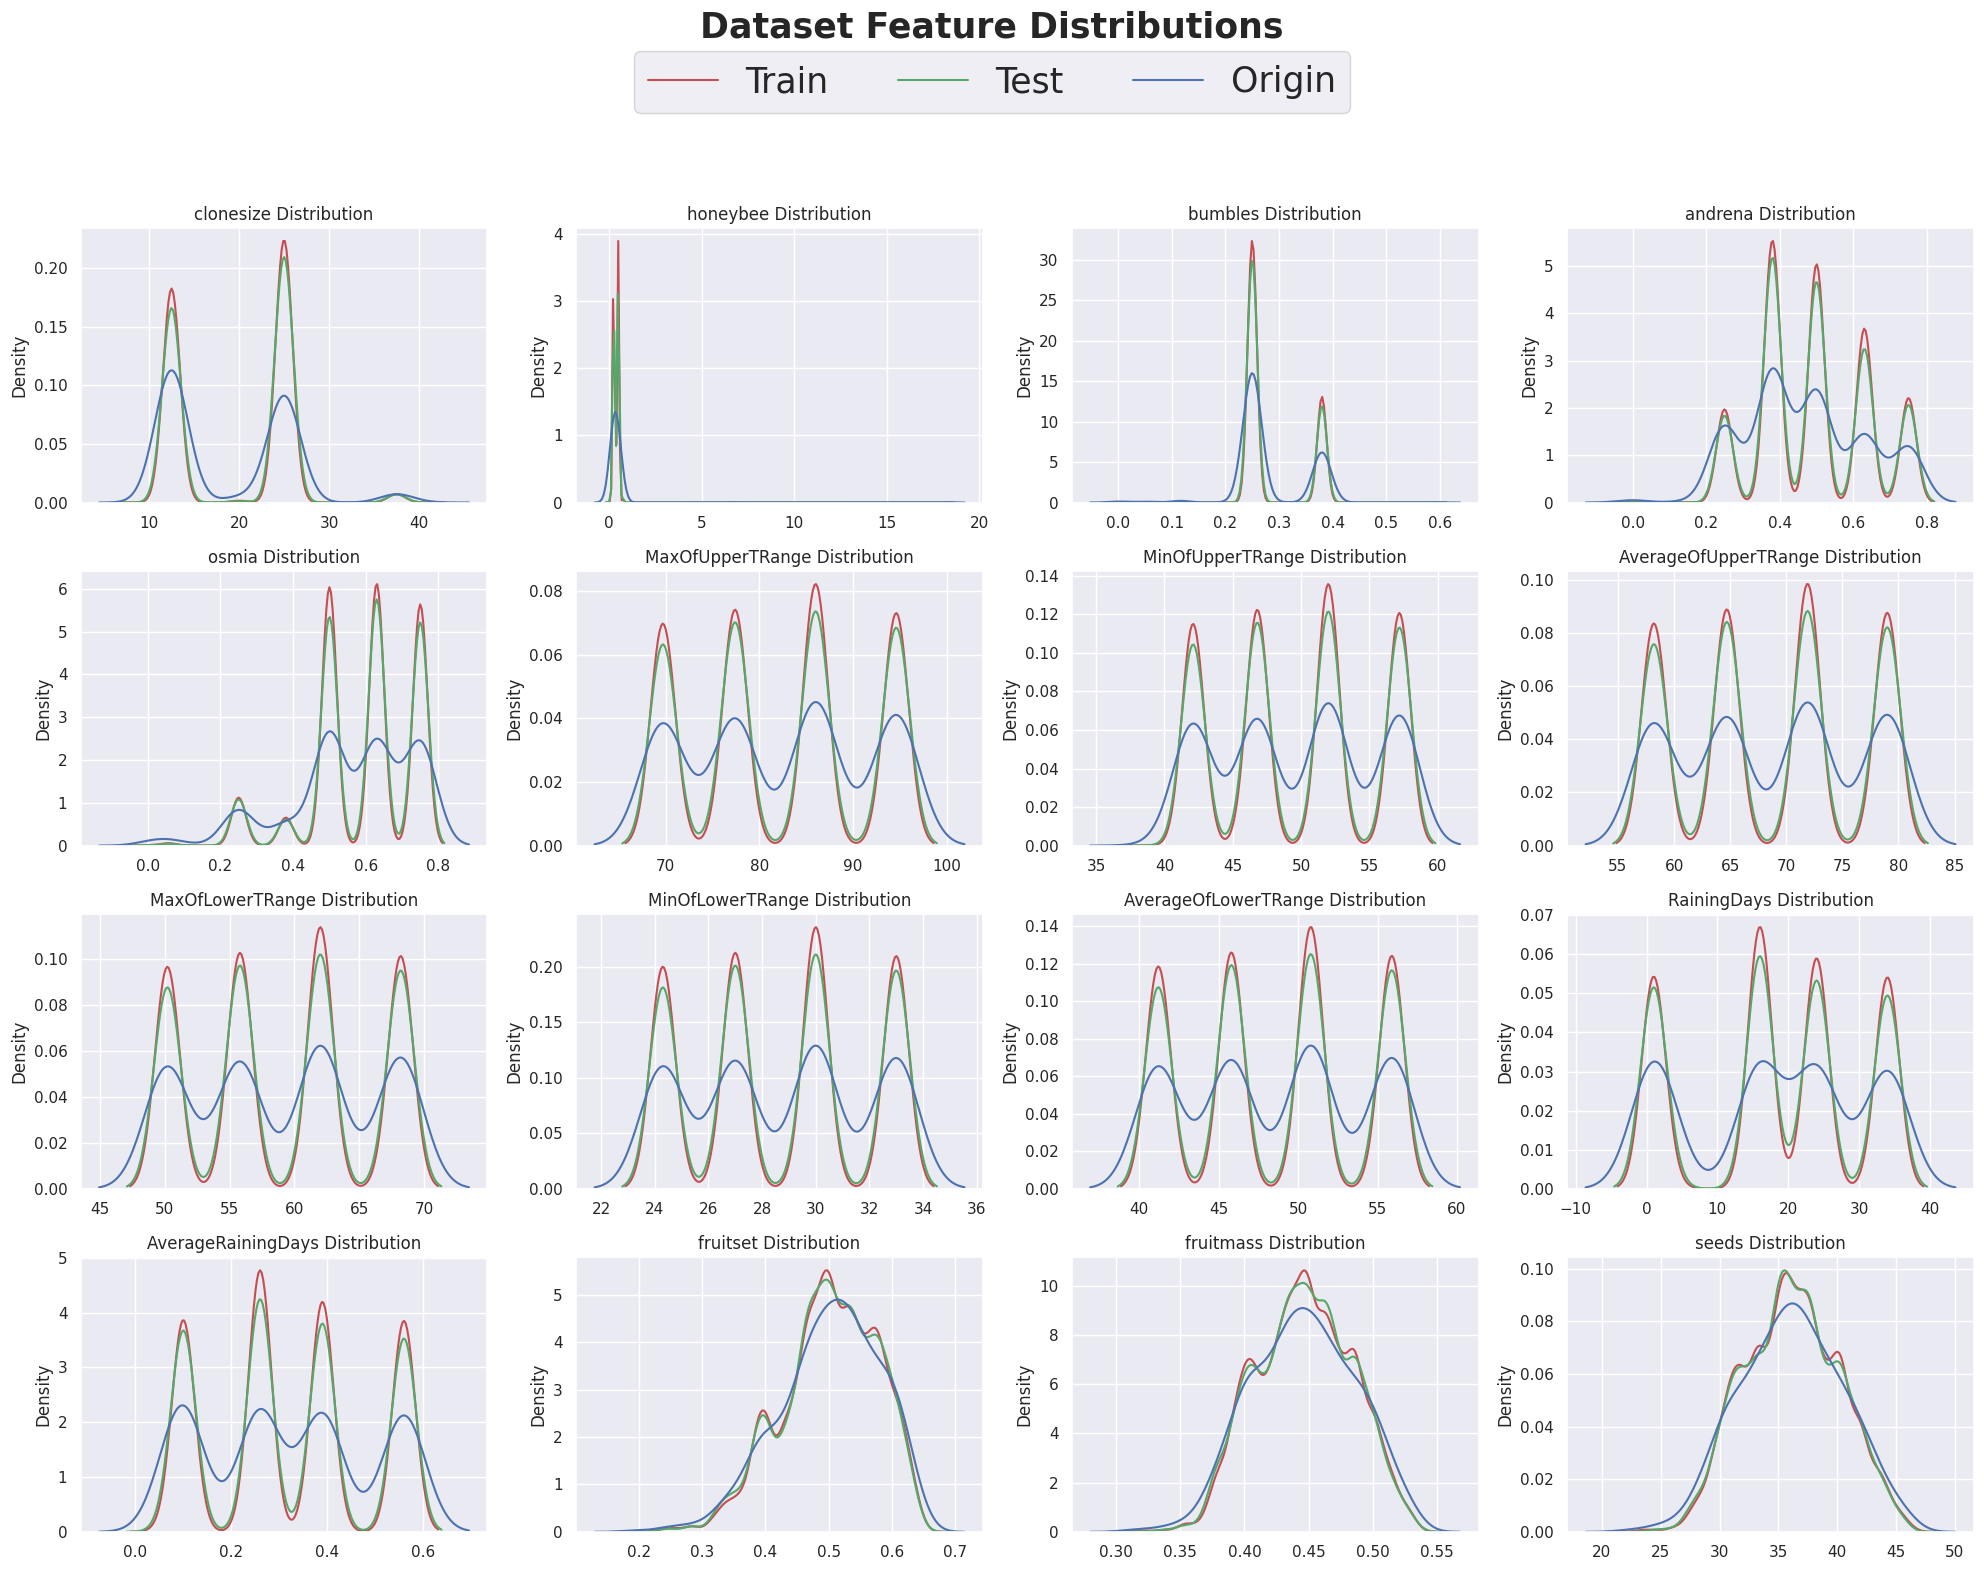

In [7]:
# kudos to @jcaliz
import math
features = data_test.columns
n_bins = 100
histplot_hyperparams = {
    'kde':True,
    'alpha':0.4,
    'stat':'percent',
    'bins':n_bins
}

columns = features
n_cols = 4
n_rows = math.ceil(len(columns)/n_cols)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
ax = ax.flatten()

for i, column in enumerate(columns):
    plot_axes = [ax[i]]
    sns.kdeplot(
        data_train[column], label='Train',
        ax=ax[i], color='r'
    )
    
    sns.kdeplot(
        data_test[column], label='Test',
        ax=ax[i], color='g'
    )
    
    sns.kdeplot(
        data_origin[column], label='Origin',
        ax=ax[i], color='b'
    )
    
    # titles
    ax[i].set_title(f'{column} Distribution');
    ax[i].set_xlabel(None)
    
    # remove axes to show only one at the end
    plot_axes = [ax[i]]
    handles = []
    labels = []
    for plot_ax in plot_axes:
        handles += plot_ax.get_legend_handles_labels()[0]
        labels += plot_ax.get_legend_handles_labels()[1]
        plot_ax.legend().remove()
    
for i in range(i+1, len(ax)):
    ax[i].axis('off')
    
fig.suptitle(f'Dataset Feature Distributions\n\n\n\n', ha='center',  fontweight='bold', fontsize=25)
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.965), fontsize=25, ncol=3)
plt.tight_layout()

## Correlation Heatmap
<details>
  <summary>Click to show/hide</summary>

  Hidden Text
</details>

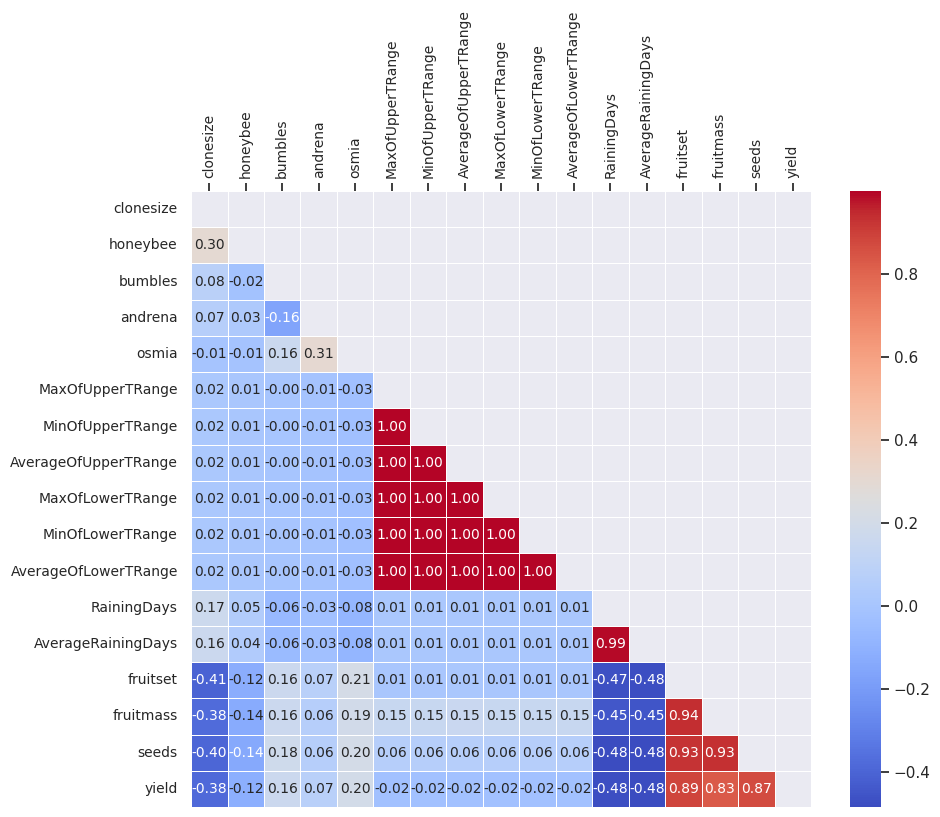

In [8]:
df = data_train

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a mask to hide the upper triangular portion
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the figure size
plt.figure(figsize=(10, 8))

# Plot the correlation heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', \
            fmt=".2f", linewidths=0.5, annot_kws={"size": 10})

# Adjust the font size of the annotations
plt.tick_params(axis='both', which='both', labelsize=10)

# Change x-axis legend position to top
plt.gca().xaxis.set_ticks_position('top')
plt.xticks(rotation=90)

# Display the heatmap
plt.show()

## Dendogram
<details>
  <summary>Click to show/hide</summary>
In the context of dendrograms, the distance parameter represents the measure of dissimilarity or distance between the features (variables) being clustered. It determines how the clustering algorithm computes the distances between the features and how they are grouped together.

The specific interpretation of the distance value depends on the method used for clustering. Different distance metrics and clustering algorithms can be employed, and each may have its own way of calculating and interpreting the distance.

In the provided example, the method='average' parameter is used in the hierarchy.linkage() function. This corresponds to the "average linkage" method, also known as the UPGMA (Unweighted Pair Group Method with Arithmetic Mean) method. In this method, the distance between two clusters is calculated as the average of the distances between all pairs of observations from the two clusters.

The distance values in the dendrogram represent the dissimilarity between the clusters being merged at each step of the hierarchical clustering. The vertical height of the dendrogram represents this dissimilarity. The longer the vertical branch, the greater the dissimilarity between the clusters being merged.

It's important to note that the interpretation of the distance value can vary depending on the context and the specific method used for clustering. Different methods may have different scales or normalization procedures for the distance values. Therefore, it's recommended to consult the documentation or literature specific to the clustering algorithm or method being used for more detailed information on interpreting the distance values in a dendrogram.
</details>

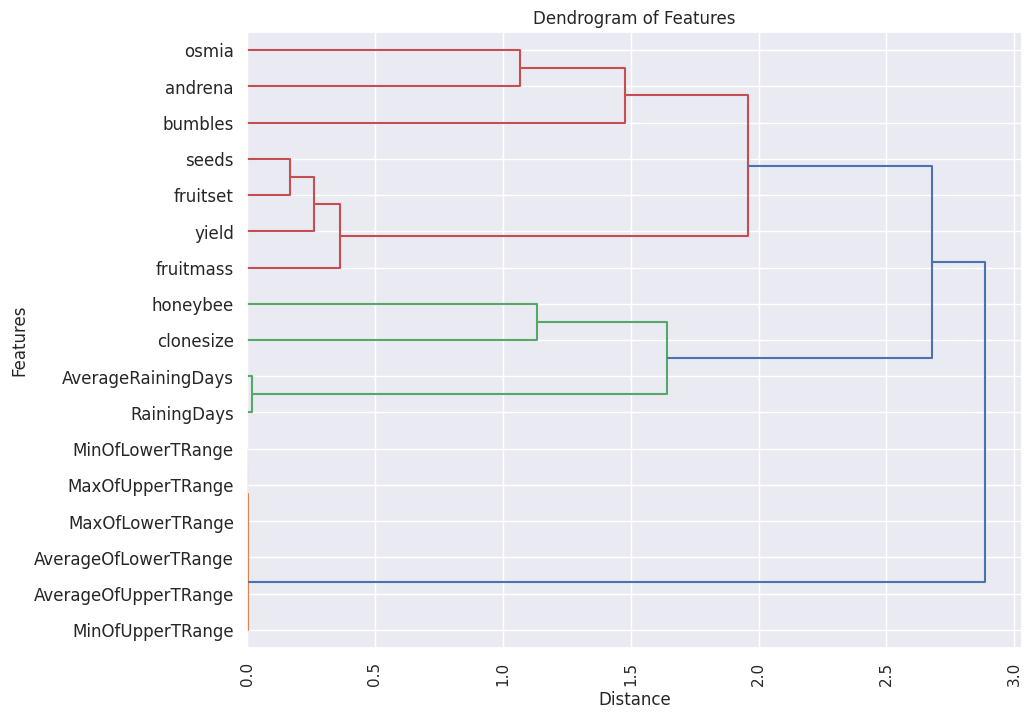

In [9]:
from scipy.cluster import hierarchy

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a linkage matrix based on the correlation matrix
linkage_matrix = hierarchy.linkage(correlation_matrix, method='average')

# Plot the dendrogram
plt.figure(figsize=(10, 8))
dendrogram = hierarchy.dendrogram(linkage_matrix, \
                                  labels=correlation_matrix.columns, \
                                  orientation='right')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set axis labels and title
plt.xlabel('Distance')
plt.ylabel('Features')
plt.title('Dendrogram of Features')

# Display the dendrogram
plt.show()


## Mutual Information

In [10]:
from sklearn.feature_selection import mutual_info_regression

X_mi = data_train.copy()
y_mi = X_mi['yield']
X_mi = X_mi.drop('yield',axis=1)

# Calculate the mutual information scores for each feature
mi_scores = mutual_info_regression(X_mi, y_mi)

# Create a list of tuples containing feature names and corresponding scores
feature_scores = [(feature_name, score) for feature_name, score in zip(X_mi.columns, mi_scores)]

# Sort the features by MI score in descending order
sorted_scores = sorted(feature_scores, key=lambda x: x[1], reverse=True)

# Print the feature names and scores in descending order
print('Mi scores:\n')
for feature_name, score in sorted_scores:
    print(f"{feature_name}: {score:.3f}")

Mi scores:

fruitset: 1.362
seeds: 1.155
fruitmass: 0.985
AverageRainingDays: 0.168
RainingDays: 0.167
clonesize: 0.110
honeybee: 0.079
andrena: 0.033
osmia: 0.032
AverageOfUpperTRange: 0.026
MinOfLowerTRange: 0.023
MaxOfUpperTRange: 0.022
MaxOfLowerTRange: 0.020
bumbles: 0.018
AverageOfLowerTRange: 0.016
MinOfUpperTRange: 0.008


## Establish baseline

Here we establish a baseline score to judge our feature engineering against.

The function below will compute the cross-validated MAE score for a feature set. We've used XGBRegressor for our model.

In [11]:
def score_dataset(X, y, model=XGBRegressor()):
    ''' 
    - Label encoding is good for XGBoost and RandomForest, but one-hot
    would be better for models like Lasso or Ridge. The `cat.codes`
    attribute holds the category levels. 
    - This approach is only suitable for when there is ordinal relationship 
    between the categories
    
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    '''
    # Below are the common 3 scoring methods for cross validation.
    # Note: Cross validation is performed after a model has been fitted to train data.
    '''
    # 1. Root mean square error (RMSE) calculation (with log y) using cross validation
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)

    '''
    '''
    # 2. Root mean square error (RMSE) calculation using cross validation
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    '''
    # 3. Mean absolute error (MAE) calculation using cross validation
    score = cross_val_score(
       model, X, y, cv=5, scoring='neg_mean_absolute_error',)
    score = -1 * score.mean()
    
    return score
    
    '''
    Sample code below to predict if RMSLE is used for score evaluation:
      model = XGBRegressor(**xgb_params)
      model.fit(X_train, np.log(y_train))
      y_pred = np.exp(model.predict(X_test))
    
    Sample code below to predict if RMSE or MAE is used for score evaluation:
      model = XGBRegressor(**xgb_params)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
    '''

## Feature Engineering



In [12]:
def preprocess(df):
   
    '''
    # One-hot encode the data (to shorten the code, we use pandas)
    X_train = pd.get_dummies(X_train)
    X_valid = pd.get_dummies(X_valid)
    X_test = pd.get_dummies(X_test)
    
    # Check for duplicates
    duplicates = data_train[data_train.duplicated()]
    print(duplicates)
    
    # Select categorical columns with relatively low cardinality (convenient but arbitrary)
    categorical_cols = [cname for cname in df.columns if df[cname].nunique() < 10 and 
                            df[cname].dtype == "object"]
    '''
    # Select numeric columns
    numeric_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64']]

    # Keep selected columns only
    cols = numeric_cols # + low_cardinality_cols
    df = df[cols]
   
    # Remove rows with missing target
    df.dropna(axis=0, inplace=True)
    
    # Create new features
    # 1. Temperature range
    df['TemperatureRange'] = df['MaxOfUpperTRange'] - df['MinOfLowerTRange']

    # 2. Temperature extremes
    threshold_high = 71.9  
    threshold_low = 50    

    df['ExtremeHighTemp'] = (df['AverageOfUpperTRange'] > threshold_high).astype(int)
    df['ExtremeLowTemp'] = (df['AverageOfLowerTRange'] < threshold_low).astype(int)

    # 3. Total bee density
    df['TotalBeeDensity'] = df['honeybee'] + df['bumbles'] + df['andrena'] + df['osmia']

    # 4. Bee species dominance
    total_density = df['honeybee'] + df['bumbles'] + df['andrena'] + df['osmia']
    df['HoneybeeDominance'] = df['honeybee'] / total_density
    df['BumblesBeeDominance'] = df['bumbles'] / total_density
    df['AndrenaBeeDominance'] = df['andrena'] / total_density
    df['OsmiaBeeDominance'] = df['osmia'] / total_density

    # 5. Rain intensity
    df['RainIntensity'] = df['AverageRainingDays'] / df['RainingDays']

    # 6. Interaction features
    df['BeeDensity_TemperatureInteraction'] = df['TotalBeeDensity'] * df['TemperatureRange']
    df['BeeDensity_RainInteraction'] = df['TotalBeeDensity'] * df['RainIntensity']

    # 7. Drop redundant columns
    cols_to_drop = ['MinOfUpperTRange',
                'AverageOfUpperTRange',
                'AverageOfLowerTRange',
                'MaxOfUpperTRange',
                'MaxOfLowerTRange',
                'MinOfUpperTRange']
    df = df.drop(columns=cols_to_drop, axis=1)
    
    return df

In [13]:
from sklearn.model_selection import train_test_split

X_origin = data_origin.copy().drop('yield',axis=1)
X_origin = preprocess(X_origin)

X = data_train.copy().drop('yield',axis=1)
X = preprocess(X)
y = data_train['yield']
# X = pd.concat(X, X_origin)

X_test = data_test.copy()
X_test = preprocess(X_test)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Making sure all columns are aligned by dropping columns that are not in X_train
X_train, X_valid = X_train.align(X_valid, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [14]:
X.head()

,clonesize,honeybee,bumbles,andrena,osmia,MinOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,...,ExtremeHighTemp,ExtremeLowTemp,TotalBeeDensity,HoneybeeDominance,BumblesBeeDominance,AndrenaBeeDominance,OsmiaBeeDominance,RainIntensity,BeeDensity_TemperatureInteraction,BeeDensity_RainInteraction
0,25.0,0.50,0.25,0.75,0.50,24.3,24.0,0.39,0.425011,0.417545,...,0,1,2.00,0.250000,0.125000,0.375000,0.250000,0.01625,90.800,0.032500
1,25.0,0.50,0.25,0.50,0.50,24.3,24.0,0.39,0.444908,0.422051,...,0,1,1.75,0.285714,0.142857,0.285714,0.285714,0.01625,79.450,0.028438
2,12.5,0.25,0.25,0.63,0.63,30.0,24.0,0.39,0.552927,0.470853,...,0,0,1.76,0.142045,0.142045,0.357955,0.357955,0.01625,98.560,0.028600
3,12.5,0.25,0.25,0.63,0.50,27.0,24.0,0.39,0.565976,0.478137,...,0,1,1.63,0.153374,0.153374,0.386503,0.306748,0.01625,82.152,0.026488
4,25.0,0.50,0.25,0.63,0.63,27.0,24.0,0.39,0.579677,0.494165,...,0,1,2.01,0.248756,0.124378,0.313433,0.313433,0.01625,101.304,0.032662


## Correlation Heatmap with New Features

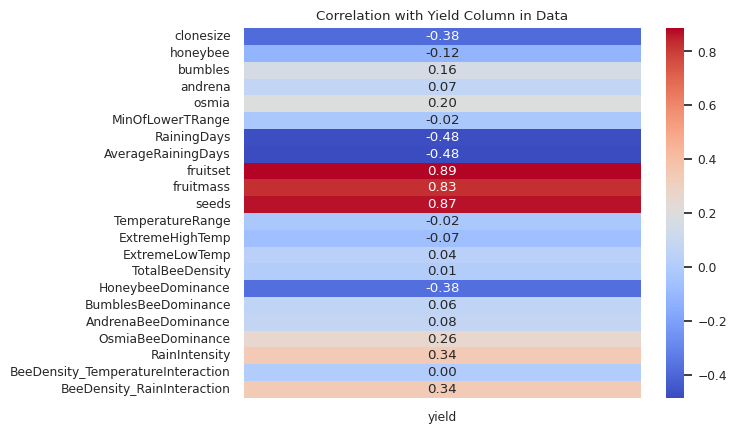

In [15]:
X_corr = X.copy()
X_corr['yield'] = y
corr = X_corr.corr()

# Extract the correlations with the target column
target_corr = corr['yield'].drop('yield')

# Create a heatmap of the correlations with the target column
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Yield Column in Data')
plt.show()

## Build XGBRegressor, LGMB and Catboost Models with Hyperparameter Optimization

In [16]:
# Define Optuna objectives for each model
def xgb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)

    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    return mae

def lgbm_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    num_leaves = trial.suggest_int("num_leaves", 31, 127)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)

    model = LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    return mae

def catboost_objective(trial):
    iterations = trial.suggest_int("iterations", 100, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2)
    depth = trial.suggest_int("depth", 3, 10)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 9)
    subsample = trial.suggest_float("subsample", 0.5, 1)

    model = CatBoostRegressor(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        subsample=subsample,
        random_state=42,
        verbose=0
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    return mae

In [17]:
'''
import optuna

def objective(trial):
    xgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    xgb = XGBRegressor(**xgb_params)
    return score_dataset(X_train, y_train, xgb)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
xgb_params = study.best_params
'''

'\nimport optuna\n\ndef objective(trial):\n    xgb_params = dict(\n        max_depth=trial.suggest_int("max_depth", 2, 10),\n        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),\n        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),\n        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),\n        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),\n        subsample=trial.suggest_float("subsample", 0.2, 1.0),\n        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),\n        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),\n    )\n    xgb = XGBRegressor(**xgb_params)\n    return score_dataset(X_train, y_train, xgb)\n\nstudy = optuna.create_study(direction="minimize")\nstudy.optimize(objective, n_trials=100)\nxgb_params = study.best_params\n'

In [18]:
'''
# unused paramters
xgb_params1 = {'max_depth': 5, 
              'learning_rate': 0.0035254017286568302, 
              'n_estimators': 7644, 
              'min_child_weight': 8, 
              'colsample_bytree': 0.43990919327885564, 
              'subsample': 0.20727962189854338, 
              'reg_alpha': 30.7155256713383, 
              'reg_lambda': 0.9874153586638605}

# Extract optuna's best parameters from Version 3
xgb_params2 = {'max_depth': 3, 
              'learning_rate': 0.01310268225523144, 
              'n_estimators': 7310, 
              'min_child_weight': 7, 
              'colsample_bytree': 0.625584317373155, 
              'subsample': 0.6954274215922782, 
              'reg_alpha': 5.827870199860091, 
              'reg_lambda': 0.005313733410692002}
'''

"\n# unused paramters\nxgb_params1 = {'max_depth': 5, \n              'learning_rate': 0.0035254017286568302, \n              'n_estimators': 7644, \n              'min_child_weight': 8, \n              'colsample_bytree': 0.43990919327885564, \n              'subsample': 0.20727962189854338, \n              'reg_alpha': 30.7155256713383, \n              'reg_lambda': 0.9874153586638605}\n\n# Extract optuna's best parameters from Version 3\nxgb_params2 = {'max_depth': 3, \n              'learning_rate': 0.01310268225523144, \n              'n_estimators': 7310, \n              'min_child_weight': 7, \n              'colsample_bytree': 0.625584317373155, \n              'subsample': 0.6954274215922782, \n              'reg_alpha': 5.827870199860091, \n              'reg_lambda': 0.005313733410692002}\n"

In [19]:
%%time
# Run Optuna optimization for each model
sampler = TPESampler(seed=42)

xgb_study = optuna.create_study(direction="minimize", sampler=sampler)
xgb_study.optimize(xgb_objective, n_trials=100)

lgbm_study = optuna.create_study(direction="minimize", sampler=sampler)
lgbm_study.optimize(lgbm_objective, n_trials=100)

catboost_study = optuna.create_study(direction="minimize", sampler=sampler)
catboost_study.optimize(catboost_objective, n_trials=100)

xgb_best_params = xgb_study.best_params
lgbm_best_params = lgbm_study.best_params
catboost_best_params = catboost_study.best_params

# Print best hyperparameters for each model from Optuna
print("Best parameters for XGBoost from Optuna: ", xgb_best_params)
print("Best parameters for LightGBM from Optuna: ", lgbm_best_params)
print("Best parameters for CatBoost from Optuna: ", catboost_best_params)

Best parameters for XGBoost from Optuna:  {'n_estimators': 276, 'learning_rate': 0.01847081408348316, 'max_depth': 7, 'subsample': 0.5157380986640149, 'colsample_bytree': 0.908041826446699}
Best parameters for LightGBM from Optuna:  {'n_estimators': 388, 'learning_rate': 0.01703337749839352, 'max_depth': 7, 'num_leaves': 82, 'subsample': 0.8658950453700404, 'colsample_bytree': 0.8389976917609476}
Best parameters for CatBoost from Optuna:  {'iterations': 446, 'learning_rate': 0.045536134254079715, 'depth': 6, 'l2_leaf_reg': 2, 'subsample': 0.6888292128989044}
CPU times: user 23min 51s, sys: 28.3 s, total: 24min 20s
Wall time: 12min 42s


## Ensemble the models

In [20]:
# Train multiple base models with the best parameters
xgb = XGBRegressor(**xgb_best_params, random_state=42)
lgbm = LGBMRegressor(**lgbm_best_params, random_state=42)
catboost = CatBoostRegressor(**catboost_best_params, random_state=42, verbose=0)

In [21]:
# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_regression, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_valid_selected = selector.transform(X_valid)
X_test_selected = selector.transform(X_test)

# Combine the base models to create an ensemble and assign weights
weights = [0.2, 0.2, 0.6]
# Combine the base models to create an ensemble
ensemble = VotingRegressor([('xgb', xgb), 
                            ('lgbm', lgbm), 
                            ('catboost', catboost)], 
                           weights=weights)
# Train the ensemble model using selected features
ensemble.fit(X_train_selected, y_train)

# Perform prediction on validation data
y_pred = ensemble.predict(X_valid_selected)
mae = mean_absolute_error(y_pred, y_valid)
print("Mean Absolute Error:" , mae)

Mean Absolute Error: 353.8795736098011


In [22]:
'''
from sklearn.metrics import mean_absolute_error

my_model = XGBRegressor(**xgb_params).fit(X_train, y_train)
y_pred = my_model.predict(X_valid)
mae = mean_absolute_error(y_pred, y_valid)
print("Mean Absolute Error:" , mae)
'''

'\nfrom sklearn.metrics import mean_absolute_error\n\nmy_model = XGBRegressor(**xgb_params).fit(X_train, y_train)\ny_pred = my_model.predict(X_valid)\nmae = mean_absolute_error(y_pred, y_valid)\nprint("Mean Absolute Error:" , mae)\n'

## Final Prediction and Submission

In [23]:
final_model = ensemble
y_pred = final_model.predict(X_test_selected)
output = pd.DataFrame({'id': id_test, 'yield': y_pred})
print(output.head())

      id        yield
0  15289  4271.422226
1  15290  6163.110838
2  15291  7219.336466
3  15292  4751.617539
4  15293  3865.188062


In [24]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [25]:
## Permutation Importance

In [26]:
'''from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# Baseline model
baseline_model = XGBRegressor(random_state=0).fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_valid)
mae = mean_absolute_error(y_pred_baseline, y_valid)
print("Mean Absolute Error:" , mae)'''

'from xgboost import XGBRegressor\nfrom sklearn.metrics import mean_absolute_error\n\n# Baseline model\nbaseline_model = XGBRegressor(random_state=0).fit(X_train, y_train)\ny_pred_baseline = baseline_model.predict(X_valid)\nmae = mean_absolute_error(y_pred_baseline, y_valid)\nprint("Mean Absolute Error:" , mae)'

In [27]:
'''import eli5
from eli5.sklearn import PermutationImportance

# Make a small change to the code below to use in this problem. 
perm = PermutationImportance(my_model_1, random_state=0).fit(X_valid, y_valid)

# uncomment the following line to visualize your results
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())'''

'import eli5\nfrom eli5.sklearn import PermutationImportance\n\n# Make a small change to the code below to use in this problem. \nperm = PermutationImportance(my_model_1, random_state=0).fit(X_valid, y_valid)\n\n# uncomment the following line to visualize your results\neli5.show_weights(perm, feature_names = X_valid.columns.tolist())'